In [1]:
from copy import deepcopy

import matplotlib.pyplot as plt
import torch
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf

from hysteresis.base import BaseHysteresis
from torchAccelerator.first_order import TorchDrift
from torchAccelerator.hysteresis import HysteresisAccelerator, HysteresisQuad

# Generate optimization data without hysteresis

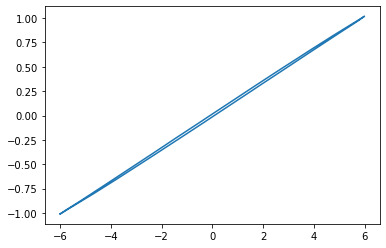

In [2]:
# Create hysteresis model
def density_function(mesh_pts, h = 0.5):
    x = mesh_pts[:, 0]
    y = mesh_pts[:, 1]
    return torch.exp(-(y - x) / h)

H = torch.load('q4034.pt')
H.trainable = False
H.reset_history()

test_applied_fields = torch.cat(
    (torch.linspace(*H.valid_domain,110) ,
     torch.flipud(torch.linspace(*H.valid_domain,110)))
)

H.regression()
M = H(test_applied_fields, return_real=True).detach()

fig,ax = plt.subplots()
ax.plot(test_applied_fields, M)
H.current()

In [3]:
#create accelerator model using hysteresis models
hmodels = [deepcopy(H), deepcopy(H), deepcopy(H)]

# define quadrupoles

kscale = 400.0
q1 = HysteresisQuad("q1", torch.tensor(0.01), hmodels[0], scale=kscale)
d1 = TorchDrift("d1", torch.tensor(1.0))
d2 = TorchDrift("d2", torch.tensor(1.0))
q2 = HysteresisQuad("q2", torch.tensor(0.01), hmodels[1], scale=kscale)
d3 = TorchDrift("d3", torch.tensor(1.0))
q3 = HysteresisQuad("q3", torch.tensor(0.01), hmodels[2], scale=kscale)

HA = HysteresisAccelerator([q1, d1, q2, d2, q3, d3])

init_beam_matrix = torch.eye(6) * 1.0e-8

# set x_rms beam size to 1 mm and rms divergence to 0.1 mrad
init_beam_matrix[0, 0] = 5.0e-3 ** 2
init_beam_matrix[1, 1] = 1.0e-4 ** 2
init_beam_matrix[2, 2] = 5.0e-3 ** 2
init_beam_matrix[3, 3] = 1.0e-4 ** 2
R = init_beam_matrix

In [4]:
q1.apply_field(torch.tensor(-6.0))
q1.current()
print(q1.hysteresis_model())

tensor([0.6525], dtype=torch.float64)


In [5]:
# create objective function - log(sqrt(RMS()))
def objective(R):
    return torch.abs(torch.sqrt(R[0,0]) - 8e-3) + torch.abs(torch.sqrt(R[2,2]) - 8e-3)

In [6]:
from botorch.models.transforms import Normalize
# define function to create model
from gpytorch.utils.errors import NotPSDError
from botorch import fit_gpytorch_model
from gpytorch import ExactMarginalLogLikelihood
from botorch.models import SingleTaskGP
from botorch.models.transforms import Standardize
from tqdm.notebook import trange
from gpytorch.likelihoods import GaussianLikelihood
from hysteresis.hybrid import ExactHybridGP


def get_model(train_X, train_Y, use_hybrid = False, h_models = None):
    if use_hybrid:
        gpmodel = ExactHybridGP(
            train_X.clone().detach().double(),
            train_Y.clone().detach().flatten().double(), 
            h_models,
        )
        
        mll = ExactMarginalLogLikelihood(gpmodel.gp.likelihood, gpmodel)
        fit_gpytorch_model(mll)
        
    else:
        std_trans = Standardize(1)
        gpmodel = SingleTaskGP(
            train_X.clone().detach().double(),
            train_Y.clone().detach().double(),
            input_transform=Normalize(train_X.shape[-1]),
            outcome_transform=std_trans
        )
        mll = ExactMarginalLogLikelihood(gpmodel.likelihood, gpmodel)
        fit_gpytorch_model(mll)
    return gpmodel

In [7]:
# define optimizer function
def optimize(
        accelerator_model,
        initial_beam_matrix,
        h_models,
        steps=50,
        use_hybrid = False
):
    iterations = steps

    # initialize with a couple of points
    train_x = torch.ones((3, 3)) * 0.25
    train_x[0] = train_x[0] * 0.0
    train_x[2] = torch.tensor((0.3,-0.6, 0.3))
    train_x = train_x*6.0
    train_y = torch.empty((3, 1))

    accelerator_model.current()

    for j in range(len(train_x)):
        accelerator_model.apply_fields({'q1': train_x[j, 0],
                                        'q2': train_x[j, 1],
                                        'q3': train_x[j, 2],})

        beam_matrix = accelerator_model(init_beam_matrix, full=False)
        #fig,ax = plt.subplots()
        #ax.plot(torch.sqrt(beam_matrix[:, 0, 0]).detach())
        #ax.plot(torch.sqrt(beam_matrix[:, 2, 2]).detach())


        train_y[j] = objective(
            accelerator_model(initial_beam_matrix)
        )

    print(train_x)
    print(train_y)

    gpmodel = get_model(train_x, train_y, use_hybrid, h_models)

    for i in trange(iterations):
        UCB = UpperConfidenceBound(gpmodel, beta=2.0, maximize=False)
        
        if use_hybrid:
            gpmodel.next()

        bounds = torch.stack([h.valid_domain for h in h_models]).T
        candidate, acq_value = optimize_acqf(
            UCB,
            bounds=bounds,
            q=1,
            num_restarts=5,
            raw_samples=20,
        )
        train_x = torch.cat((train_x, candidate))

        # apply candidate
        accelerator_model.apply_fields({'q1': candidate[0,0],
                                        'q2': candidate[0,1],
                                        'q3': candidate[0,2]})

        # make next measurement
        bs = objective(
            accelerator_model(initial_beam_matrix)
        ).reshape(1, 1)
        train_y = torch.cat((train_y.clone(), bs.clone()))
        #print(f'{candidate.numpy()}:{float(bs)}')
        # train new model
        try:
            gpmodel = get_model(train_x, train_y, use_hybrid, h_models)
        except NotPSDError:
            pass

    return train_x, train_y, gpmodel

## Do optimization

In [8]:
use_hybrid = True
train_X_data, train_Y_data, model = optimize(
    HA,
    R,
    hmodels,
    steps=50,
    use_hybrid=use_hybrid
)

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 1.5000,  1.5000,  1.5000],
        [ 1.8000, -3.6000,  1.8000]])
tensor([[0.0058],
        [0.0586],
        [0.0357]], grad_fn=<CopySlices>)


  0%|          | 0/50 [00:00<?, ?it/s]

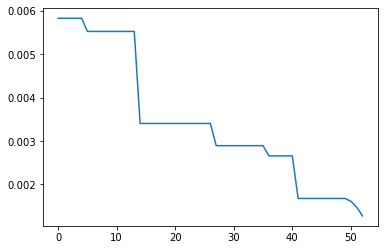

In [9]:
def get_best(input):
    out = []
    for i in range(len(input)):
        out += [torch.min(input[:i+1])]
    return torch.tensor(out)

fig,ax = plt.subplots()
best = get_best(train_Y_data.flatten().detach())
ax.plot(best)

{'q1': tensor(-1.0721, dtype=torch.float64), 'q2': tensor(-0.1347, dtype=torch.float64), 'q3': tensor(1.2458, dtype=torch.float64)}
tensor(0.0013, grad_fn=<AddBackward0>)
tensor(0.0013, grad_fn=<MinBackward1>)


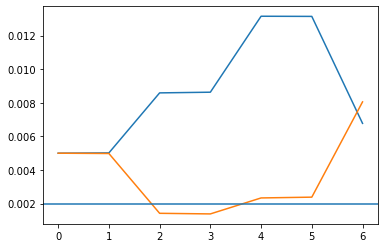

In [10]:
best_settings = train_X_data[torch.argmin(train_Y_data)]

# apply candidate
print(dict(zip(['q1','q2','q3'], best_settings)))
HA.apply_fields(dict(zip(['q1','q2','q3'], best_settings)))


beam_matrix = HA(init_beam_matrix, full=False)
fig,ax = plt.subplots()
ax.plot(torch.sqrt(beam_matrix[:, 0, 0]).detach())
ax.plot(torch.sqrt(beam_matrix[:, 2, 2]).detach())

ax.axhline(2.0e-3)
print(objective(beam_matrix[-1]))
print(torch.min(train_Y_data))

In [11]:
model = get_model(train_X_data, train_Y_data, use_hybrid = use_hybrid, h_models = hmodels)

# optimize model to find the best point
UCB = UpperConfidenceBound(model, beta=0.00001, maximize=False)
try:
    model.next()
except AttributeError:
    pass

bounds = torch.stack([h.valid_domain for h in hmodels]).T
candidate, acq_value = optimize_acqf(
    UCB,
    bounds=bounds,
    q=1,
    num_restarts=100,
    raw_samples=100,
)
print(candidate)

tensor([[-1.0434, -0.2747,  1.3303]], dtype=torch.float64)


tensor(0.0013, grad_fn=<AddBackward0>)
tensor(0.0013, grad_fn=<MinBackward1>)


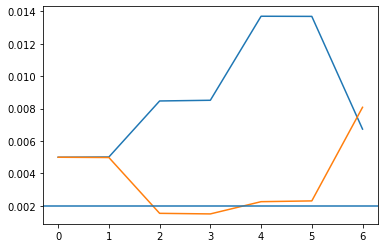

In [12]:
HA.apply_fields(dict(zip(['q1','q2','q3'], candidate.flatten())))

beam_matrix = HA(init_beam_matrix, full=False)
fig,ax = plt.subplots()
ax.plot(torch.sqrt(beam_matrix[:, 0, 0]).detach())
ax.plot(torch.sqrt(beam_matrix[:, 2, 2]).detach())

ax.axhline(2.0e-3)
print(objective(beam_matrix[-1]))
print(torch.min(train_Y_data))